# Individualized synthetic data

let $x_{i,t}$ be the $i^{th}$ patient at time $t$. We want the labeling function to depend on the history of events. **We also assume the progression of a disease for a particular patient can be inferred from patient history**.

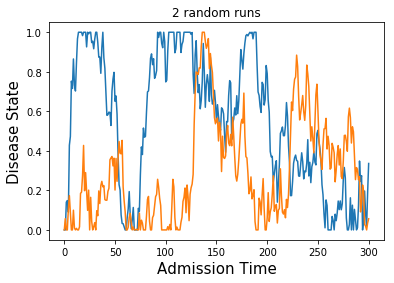

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def random_walk(T=30, s0=0, vmin=0, vmax=1, step=0.1, 
                random_function=lambda: np.random.randn()):
    path = [s0]
    for t in range(T):
        s = path[-1]
        ns = s + random_function() * step
        path.append(max(min(vmax, ns), 0))
    
    return path

nruns = 2
for _ in range(nruns):
    path = random_walk(T=300)
    plt.plot(path)
    
plt.title('{} random runs'.format(nruns))
plt.xlabel('Admission Time', fontsize=15)
plt.ylabel('Disease State', fontsize=15) # need a specific example of the change of risk factors
plt.show()

In certain realworld diseases, disease state is not reversable, so our synthetic data could be simplified as 

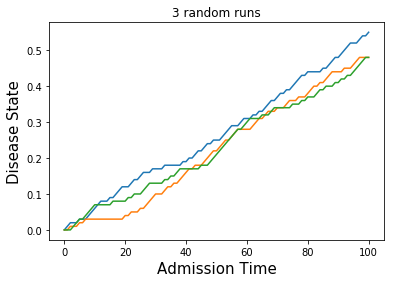

In [3]:
nruns = 3
for _ in range(nruns):
    path = random_walk(T=100, random_function=lambda: np.random.choice([0,0.1]))
    plt.plot(path)
    
plt.title('{} random runs'.format(nruns))
plt.xlabel('Admission Time', fontsize=15)
plt.ylabel('Disease State', fontsize=15) # need a specific example of the change of risk factors
plt.show()

Once we have the disease progression plot, we use the progression to index into a model to use.

We assume the problem is a quadratic and depends on two sets of weights $(w_{attn}, w_{feature})$, where $w_{attn}$ defines attention over past input and $w_{feature}$ defines feature importance. 

For each disease state $s$, the attention and feature importance vector is changing, but we assume the change is smooth with respect to $s$. The following plot gives an illustration of the relationship between $w$ and $s$.

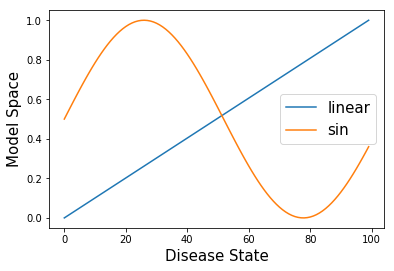

In [4]:
def model_vs_state(f=lambda x: x):
    s = np.linspace(0, 1)
    
s = np.linspace(0, 1, 100)
plt.plot(s, label='linear')
plt.plot(np.sin(s*6)/2 + 1/2, label='sin')

plt.legend(fontsize=15)
plt.ylabel('Model Space', fontsize=15)
plt.xlabel('Disease State', fontsize=15)
plt.show()

The state to model weight mapping maybe complicated, but let's assume is just a simple linear relationship

# MeLU vs. Leaky ReLU

In [175]:
class MeLU(torch.nn.Module): # mixture of expert linear unit

    def __init__(self, s=0.01, a=1, b=0):
        super(MeLU, self).__init__()
        '''
        s: slope of left part (learned: optional)
        '''
        self.s = s
        self.a = torch.nn.Parameter(torch.Tensor([a]))
        self.b = torch.nn.Parameter(torch.Tensor([b]))

    def forward(self, x):
        r = x
        l = self.s * x
        m = torch.sigmoid(self.a * (x - self.b))
        return (1-m) * l + m * r
    
class MPLU(torch.nn.Module): # mixture of piecewise linear unit                                                                                                             
    '''                                                                                                                                                                                                                                                                         
     same as above; just use a linear piece to combine instead of                                                                                                                                                                                                                
    mixture of the output                                                                                                                                                                                                                                                       
    '''                                                                                                                                                                                                                                                                         
    def __init__(self, s=0.01, a=1, b=0):                                                                                                                                                                                                                                       
        super(MPLU, self).__init__()                                                                                                                                                                                                                                            
        '''                                                                                                                                                                                                                                                                     
        s: slope of left part (learned: optional)                                                                                                                                                                                                                               
        a: width of middle piece; large a -> large width                                                                                                                                                                                                                        
        b: bias of the switching point                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                                     
        self.s = s                                                                                                                                                                                                                                                              
        self.a = torch.nn.Parameter(torch.Tensor([a]))                                                                                                                                                                                                                          
        self.b = torch.nn.Parameter(torch.Tensor([b]))                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                
    def forward(self, x):                                                                                                                                                                                                                                                       
        w = torch.nn.functional.softplus(self.a)                                                                                                                                                                                                                                
        o = x.clone()                                                                                                                                                                                                                                                           
        o[x <= (self.b - w)] = self.s * x[x <= (self.b - w)]                                                                                                                                                                                                                    
        m = (x > (self.b - w)) * (x < self.b)  
        o[m] = self.s * (self.b - w) + (self.b - self.s * (self.b - w)) / w * (x[m] - self.b + w)                                                                                                                                                                                       
        return o                                          
    
class SReLU(torch.nn.Module):                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                
    '''                                                                                                                                                                                                                                                                         
    This aaai2016 paper has an interesting discussion about initialization and                                                                                                                                                                                                  
    freezing schme to learn the individual parameters                                                                                                                                                                                                                           
    '''                                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                
    def __init__(self, l=0, r=1, al=0.01, ar=1): # init to leaky relu                                                                                                                                                                                                           
        super(SReLU, self).__init__()
        self.l = torch.nn.Parameter(torch.Tensor([l]))                                                                                                                                                                                                                          
        self.r = torch.nn.Parameter(torch.Tensor([r]))                                                                                                                                                                                                                           
        self.al = torch.nn.Parameter(torch.Tensor([al]))                                                                                                                                                                                                                        
        self.ar = torch.nn.Parameter(torch.Tensor([ar]))                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                
    def forward(self, x):                                                                                                                                                                                                                                                       
        o = x.clone()                                                                                                                                                                                                                                                           
        o[x >= self.r]  = self.r + self.ar * (x[x >= self.r] - self.r)                                                                                                                                                                                                          
        o[x <= self.l]  = self.l + self.al * (x[x <= self.l] - self.l)                                                                                                                                                                                                          
        return o   


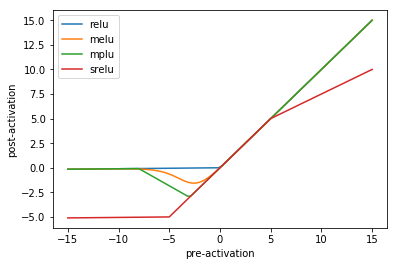

In [177]:
x = torch.linspace(-15, 15, 100)

relu = torch.nn.LeakyReLU()
y1 = relu(x)
melu = MeLU(a=1, b=-3)
y2 = melu(x)
mplu = MPLU(a=5, b=-3)
y3 = mplu(x)
srelu = SReLU(l=-5, r=5, al=0.01, ar=0.5) # the other baseline
y4 = srelu(x)

plt.plot(x.numpy(), y1.detach().numpy(), label='relu')
plt.plot(x.numpy(), y2.detach().numpy(), label='melu')
plt.plot(x.numpy(), y3.detach().numpy(), label='mplu')
plt.plot(x.numpy(), y4.detach().numpy(), label='srelu')

plt.legend()
plt.xlabel('pre-activation')
plt.ylabel('post-activation')
plt.show()

before training


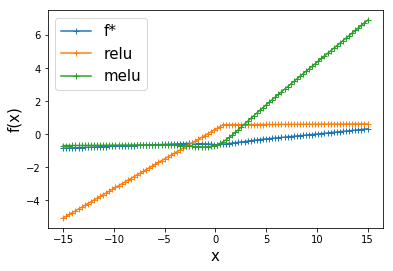

after training


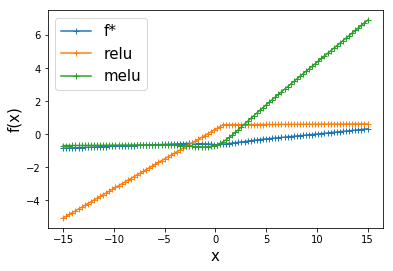

In [202]:
class SimpleNet(torch.nn.Module):
    '''
    linear x activation x linear network
    inspired by https://www.youtube.com/watch?v=-zQL9KYnQTc&list=WL&index=74
    '''
    def __init__(self, d, activation, n_in=1, n_out=1):
        super(SimpleNet, self).__init__()
        self.d = d # hidden size
        self.first_layer = torch.nn.Linear(n_in, d)
        self.activation = activation
        self.last_layer = torch.nn.Linear(d, n_out)
        
    def forward(self, x):
        return self.last_layer(self.activation(self.first_layer(x)))
    
d = 10
f_star = SimpleNet(d, torch.nn.ReLU())
relu_net = SimpleNet(1, torch.nn.LeakyReLU())
melu_net = SimpleNet(1, MeLU())

x = torch.linspace(-15, 15, 100).view(-1, 1)
y = f_star(x)
loader = data.TensorDataset(x, y)

print('before training')
plt.plot(x.numpy(), f_star(x).detach().numpy(), '-+', label='f*')
plt.plot(x.numpy(), relu_net(x).detach().numpy(), '-+', label='relu')
plt.plot(x.numpy(), melu_net(x).detach().numpy(), '-+', label='melu')
plt.xlabel('x', fontsize=15)
plt.ylabel('f(x)', fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('after training')
plt.plot(x.numpy(), f_star(x).detach().numpy(), '-+', label='f*')
plt.plot(x.numpy(), relu_net(x).detach().numpy(), '-+', label='relu')
plt.plot(x.numpy(), melu_net(x).detach().numpy(), '-+', label='melu')
plt.xlabel('x', fontsize=15)
plt.ylabel('f(x)', fontsize=15)
plt.legend(fontsize=15)
plt.show()


# bayesian credible learning

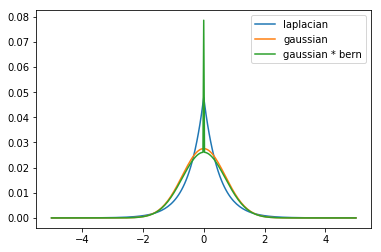

In [292]:
normalize = lambda x: x / x.sum()
lap = lambda x: np.exp(-np.abs(x) * 2)
gas = lambda x: np.exp(-x**2)
p = 0.95
gas_x_bern = lambda x: p * gas(x) + (1-p) * (x==0) * sum(gas(x)) / p

x = np.array(sorted(list(np.linspace(-5,5,200)) + [0]))
plt.plot(x, normalize(lap(x)), label='laplacian')
plt.plot(x, normalize(gas(x)), label='gaussian')
plt.plot(x, normalize(gas_x_bern(x)), label='gaussian * bern')

plt.legend()
plt.show()


Another explanation of why l1 + l2 does not work: notice the dependence on m


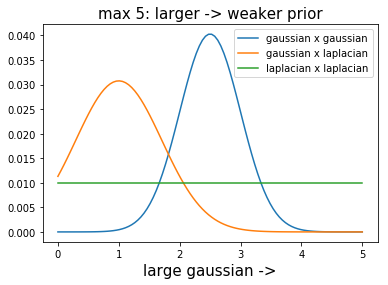

In [303]:
print('Another explanation of why l1 + l2 does not work: notice the dependence on m')
m = 5
x = np.linspace(0, m, 100)
plt.plot(x, normalize(gas(x) * gas(m-x)), label='gaussian x gaussian')
plt.plot(x, normalize(gas(x) * lap(m-x)), label='gaussian x laplacian')
plt.plot(x, normalize(lap(x) * lap(m-x)), label='laplacian x laplacian')
#plt.plot(x, normalize(gas(x) * gas_x_bern(m-x)), label='gaussian x gauss*bern')

plt.xlabel('large gaussian ->', fontsize=15)
plt.title('max {}: larger -> weaker prior'.format(m), fontsize=15)
plt.legend()
plt.show()

**Variational Inference**

$\log p(x) = ELBO(q, \theta) + KL(q(\theta) || p(\theta | x))$

$ELBO(q, \theta) = \mathbb{E}_{q(\theta)} \log p(x|\theta)  - \mathbb{E}_{q(\theta)} (\log q(\theta) - \log p(\theta))$

It should be clear that if we ignore the later term, we are essentially assuming uniform distribution on $\theta$.

We use a multivariate gaussian as variational distribution $q$. We use parametric variational inference, with parameters $L \in \mathbb{R}^{d \times c}$ and $\mu \in \mathbb{R}^d$ with $c \leq d$. We have
$$\theta \sim \mathbb{N}(\mu, LL^T)$$

With a gaussian prior and guassian likelihood, the covariance matrix is $(\Sigma_{prior} + X^T X)^{-1}$. This says that 2 highly correlated features will become highly negatively correlated. Also note that with no prior, the optimal solution is MLE (may not drive variance to 0 though).

KL in general may not be trackable, use other measures to approximate, eg., make mu part exact and if this is still not feasible, try mcmc or I can try to restrict q to have useful property by initialize its parameters.

Note that when I do prediction, I just need to take the mean of theta if the loss function is MSE

In [146]:
import torch
from torch.utils import data
import tqdm
import seaborn as sns
import pandas as pd
from scipy.linalg import block_diag
import math

def genCovX(C, n): # helper function to create N(0, C)
    # C is the covariance matrice (assume to be psd)
    # n is number of examples
    C = np.array(C)
    A = np.linalg.cholesky(C)
    d, _ = C.shape
    Z = np.random.randn(n, d)
    X = Z.dot(A.T) 
    return X.astype(np.float32)

class Q(torch.nn.Module):
    
    def __init__(self, d, c):
        super(Q, self).__init__()
        self.d = d
        self.c = c
        # todo: right now this approximation only does for the first c columns
        # need to support choosing which columns
        self.L = torch.nn.Parameter(torch.randn(d, c))
        self.mu = torch.nn.Parameter(torch.randn(d, 1))
        
    def forward(self, bs=10): # sample
        eps = torch.randn(bs, self.c, 1)
        theta = torch.matmul(self.L, eps) + self.mu
        return theta.squeeze(2) # (bs, d)
    
class Q2(torch.nn.Module):
    '''the standard mean field approximation'''
    def __init__(self, d, c='dummy'):
        super(Q2, self).__init__()
        self.d = d
        self.c = d # ignore c b/c we use mean field: assume independence
        self.sqrt_diag = torch.nn.Parameter(torch.randn(d))
        self.L = torch.diag(self.sqrt_diag)
        self.mu = torch.nn.Parameter(torch.randn(d, 1))
        
    def forward(self, bs=10): # sample
        eps = torch.randn(bs, self.c, 1)
        theta = torch.matmul(self.L, eps) + self.mu
        return theta.squeeze(2) # (bs, d)
        
def bdot(a, b): # batch wise dot product
    return (a * b).sum(-1).unsqueeze(-1)

def forward(theta, x):
    return bdot(theta, x)

def KL_l1(param_prior, param_post):
    # a proxy for KL
    l = 0
    for pri, post in zip(param_prior, param_post):
        l += (abs(pri - post)).sum()
    return l

def KL_l2(param_prior, param_post):
    # a proxy for KL
    l = 0
    for pri, post in zip(param_prior, param_post):
        l += ((pri - post)**2).sum()
    return l

def cov_(L):
    return L.mm(L.t())

def corr(L):
    cov = cov_(L)
    d = cov.diag().view(-1, 1)
    denom = torch.sqrt(d.mm(d.t()))
    return cov / denom

def train(q, loader, bs, KL_coef, prior_width, KL, criterion, opt, n_epochs, constrain_L=True):
    for i in tqdm.tqdm(range(n_epochs)):
        for x, y in loader:
            theta = q(bs) # sampling
            o = forward(theta, x)

            q.zero_grad() # just replace the latter KL part with EYE
            # the alignment by L is the reason why appproximation only works for first few coordinate
            if constrain_L:
                l = criterion(o, y) + KL_coef * KL([np.sqrt(prior_width) * torch.eye(q.d)[:,:q.c], 
                                                    1 / prior_width * torch.zeros(d, 1)], 
                                                   [q.L, q.mu])
            else:
                l = criterion(o, y) + KL_coef * KL([prior_width * torch.eye(q.d), 
                                                    1 / prior_width * torch.zeros(d, 1)], 
                                                   [cov_(q.L), q.mu])
            
            l.backward()
            opt.step()

def getCov(group_corr, n_per_groups, d):
    assert sum(n_per_groups) == d, 'must sum to d'
    blocks = []
    for n_per_group in n_per_groups:
        base = np.diag(np.ones(n_per_group))
        base[base == 0] = group_corr
        blocks.append(base)
    covariance = block_diag(*blocks)
    return covariance

In [150]:
d = 9
group_corr = 0.99
n_per_groups = [1, 1, 1, 1, 5]
covariance = getCov(group_corr, n_per_groups, d)   
n = 300
bs = 10
real_theta = (3 * torch.ones(d)).view(1, d)

# set ground truth
f = torch.nn.Linear(d, 1)
f.weight.data = real_theta
f.bias.data.fill_(0)

# define dataset
X = genCovX(covariance, n)
X = torch.from_numpy(X)
y = f(X).detach()
dataset = data.TensorDataset(X, y)
loader = data.DataLoader(dataset, batch_size=bs)

In [167]:
c = 9 # cov_approximation number
n_epochs = 1000 # 2000
q = Q(d, c) # Q2(d, c)
opt = torch.optim.Adam(q.parameters())    
KL = KL_l2
KL_coef = 0.1
prior_width = 100
constrain_L = True # doesn't seem to make a different when KL_coef is adjusted
criterion = torch.nn.MSELoss()

####### train
q_prior_cov = cov_(q.L).clone().detach().numpy()
q_prior_corr = corr(q.L).clone().detach().numpy()
q_prior_mean = q.mu.clone().clone().detach().numpy().ravel()

train(q, loader, bs, KL_coef, prior_width, KL, criterion, opt, n_epochs, constrain_L)
    
q_post_cov = cov_(q.L).clone().detach().numpy()
q_post_corr = corr(q.L).clone().detach().numpy()
q_post_mean = q.mu.clone().detach().numpy().ravel()

100%|██████████| 1000/1000 [00:23<00:00, 41.95it/s]


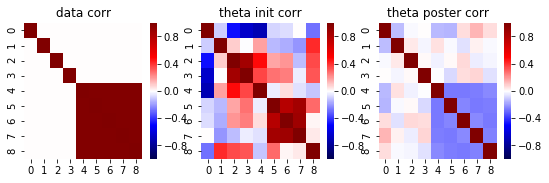

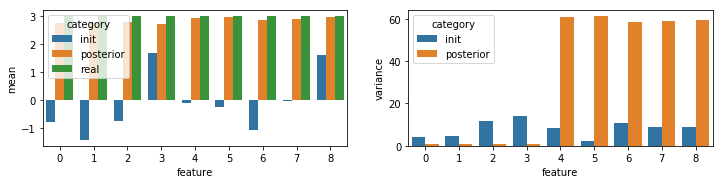

In [159]:
######## plotting code
fig = plt.figure(figsize=(9, 2.5))
ax = fig.add_subplot(1, 3, 1)
diag_cov = np.diag(np.array(covariance)).reshape(-1, 1)
sns.heatmap(covariance / np.sqrt(diag_cov.dot(diag_cov.T)), vmin=-1, vmax=1, cmap='seismic')
ax.title.set_text('data corr')

ax = fig.add_subplot(1, 3, 2)
sns.heatmap(q_prior_corr, vmin=-1, vmax=1, cmap='seismic')
ax.title.set_text('theta init corr')

ax = fig.add_subplot(1, 3, 3)
sns.heatmap(q_post_corr, vmin=-1, vmax=1, cmap='seismic')
ax.title.set_text('theta poster corr')
plt.show()

fig = plt.figure(figsize=(12, 2.5))
fig.add_subplot(1, 2, 1)
df = pd.DataFrame({'feature': list(range(d)) + list(range(d)) + list(range(d)), 
                   'mean': list(q_prior_mean) + list(q_post_mean) + list(real_theta.numpy().ravel()), 
                   'category': (['init'] * d) + (['posterior'] * d) + (['real'] * d)})
sns.barplot(x='feature', y='mean', hue='category', data=df)

fig.add_subplot(1, 2, 2)
df = pd.DataFrame({'feature': list(range(d)) + list(range(d)), 
                   'variance': list(np.diag(q_prior_cov)) + list(np.diag(q_post_cov)), 
                   'category': (['init'] * d) + (['posterior'] * d)})
sns.barplot(x='feature', y='variance', hue='category', data=df)
plt.show()

In [168]:
q()

tensor([[  3.3008,   3.7097,   1.1921,   2.8497,   2.5538,  -6.2118,   1.6237,
          12.5370,   4.2385],
        [  3.8690,   1.7005,   2.0957,   3.2106,   0.2622,  -2.8609,   9.6437,
           1.6617,   5.9352],
        [  4.2209,   2.9294,   2.6711,   2.5623,  -5.7475,   6.8222,  -0.7132,
           1.1461,  12.3461],
        [  2.3133,   3.3327,   3.3308,   2.9780,  -4.3469,  15.9154,  13.6017,
         -12.9464,   1.2411],
        [  4.5727,   1.4904,   2.4201,   1.8921,  -5.4044,  -1.7961,  15.5191,
           1.4479,   4.4249],
        [  1.6976,   1.9684,   2.0395,   3.6160,  -0.5715,  12.2944,   4.1270,
         -14.6276,  14.0169],
        [  4.1628,   2.9154,   3.3949,   1.6937, -16.8050,   7.8322,   7.2272,
           8.9647,   7.1719],
        [  2.1858,   2.9624,   3.0200,   1.3941,  -5.9404,   7.9679,  -5.6728,
           3.3180,  15.3911],
        [  2.4063,   2.2026,   2.7682,   2.1958,  10.2336,   2.8016,   2.6717,
          -1.8197,   1.0191],
        [  0.6233, 